rs887344 is on chrom 5:149549022 T>C , we use the cross validation fold with chrom 5 in test set (split 4)

In [1]:
snp='rs887344'
fold=4
snp_chrom="chr5"
snp_pos=149549022
ref="T"
alt="C"

In [2]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [3]:
from keras.models import load_model

Using TensorFlow backend.


In [4]:
import pysam
# SNP is at position 101 in the 200 bp MPRA construct 
def get_inputs(chrom,snp_pos,flank=100,ref="/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa"):
    ref=pysam.FastaFile(ref)
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1],'N':[0,0,0,0]}
    snp_pos=snp_pos-1 #convert to 0-indexing
    left_flank=ref.fetch(chrom,snp_pos-flank,snp_pos)
    print(left_flank[-10::])
    right_flank=ref.fetch(chrom,snp_pos+1,snp_pos+flank)
    print(right_flank[0:10])
    encoded=dict() 
    seqs=dict()
    for base in ['A','C','G','T']: 
        curseq=left_flank+base+right_flank
        seqs[base]=curseq
        encoded[base]=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in curseq]),0),0)
    return encoded,seqs

In [5]:
from abstention.calibration import PlattScaling, IsotonicRegression
from scipy.special import logit 

In [6]:
##load the model 
import pickle
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
from kerasAC.custom_losses import get_ambig_binary_crossentropy
import numpy as np 
custom_objects={"sensitivity":tpr,
                "specificity":tnr,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1,
                "ambig_binary_crossentropy":get_ambig_binary_crossentropy()}

model=load_model("v4/gecco.classification.SummitWithin200bpCenter."+str(fold),custom_objects=custom_objects)
predictions=pickle.load(open("/srv/scratch/annashch/deeplearning/gecco/crossvalid/v4/predictions."+str(fold),'rb'))
test_set_prediction_logits=predictions[-2]
test_set_labels=predictions[1]
#don't calibrate on nan inputs
try:
    test_set_labels=test_set_labels.values
except:
    pass
  
calibration_functions=dict() 
for i in range(5):
    nonambiguous_indices=np.argwhere(~np.isnan(test_set_labels[:,i]))
    classification_calibration_func = PlattScaling()(
    valid_preacts=test_set_prediction_logits[nonambiguous_indices,i],
    valid_labels=test_set_labels[nonambiguous_indices,i])
    calibration_functions[i]=classification_calibration_func

Platt scaling coef: 1.1758591766641238 ; intercept: -0.8289996481603451
Platt scaling coef: 1.0898230729232306 ; intercept: -1.6443325976586447
Platt scaling coef: 1.17809987787294 ; intercept: -1.75510666470306
Platt scaling coef: 1.255547330273848 ; intercept: -1.0738490853540972
Platt scaling coef: 1.3162350010125263 ; intercept: -0.5561861044695348


In [7]:
#get deepLIFT function
from dragonn.tutorial_utils import * 
from dragonn.utils import one_hot_encode
from concise.utils.plot import seqlogo, seqlogo_fig


In [8]:
#Now, pad to 1000 bp by using a 500 bp flank 
X,seqs=get_inputs(snp_chrom,snp_pos,flank=500)

AGCCCTCTTC
GCAGAGGATG


In [9]:
tasks=["Healthy",'Tumor',"SW480","HCT116","COLO205"]
bases= ['A','C','G','T']

In [10]:

## pretty print
print('\t'+'\t'.join(tasks))
# get the model predictions 
for base in ['A','C','G','T']: 
    cur_prediction=model.predict(X[base])
    print("uncalibrated:"+base+'\t'+'\t'.join([str(i) for i in cur_prediction]))
    calibrated_predictions=[] 
for base in ['A','C','G','T']: 
    cur_prediction=model.predict(X[base])
    calibrated_predictions=[]     
    for i in range(len(tasks)): 
        calibrated_predictions.append(calibration_functions[i](logit(cur_prediction)[0,i])[0])
    print("calibrated:"+base+'\t'+'\t'.join([str(round(i,3)) for i in calibrated_predictions]))

	Healthy	Tumor	SW480	HCT116	COLO205
uncalibrated:A	[0.00567657 0.06399786 0.014723   0.00495446 0.01332361]
uncalibrated:C	[0.00620448 0.07256235 0.01107641 0.00377842 0.01340411]
uncalibrated:G	[0.00647297 0.07691281 0.01056592 0.00396961 0.01424385]
uncalibrated:T	[0.00556332 0.06198125 0.01354446 0.00467387 0.0132645 ]
calibrated:A	0.001	0.01	0.001	0.0	0.002
calibrated:C	0.001	0.012	0.001	0.0	0.002
calibrated:G	0.001	0.013	0.001	0.0	0.002
calibrated:T	0.001	0.01	0.001	0.0	0.002


## Grad x input

In [11]:
from keras import backend as K 
def get_grad_by_input(model,inputs):
    grad_tensor=K.gradients(model.layers[-2].output,model.layers[0].input)
    grad_func = K.function([model.layers[0].input,K.learning_phase()], grad_tensor)
    gradient = grad_func([inputs, False])[0]
    normed_gradient = gradient-np.mean(gradient, axis=3)[:,:,:,None]
    normed_grad_times_inp = normed_gradient*inputs
    return normed_grad_times_inp.squeeze()

In [12]:
gradxinput_ref=get_grad_by_input(model,X[ref])

In [13]:
gradxinput_alt=get_grad_by_input(model,X[alt])

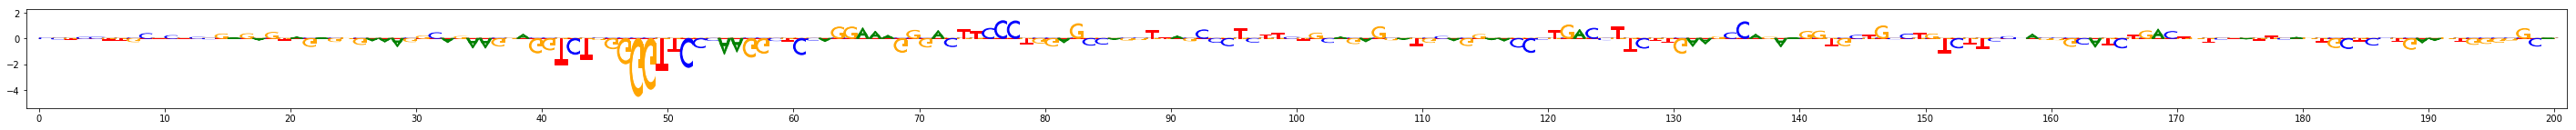

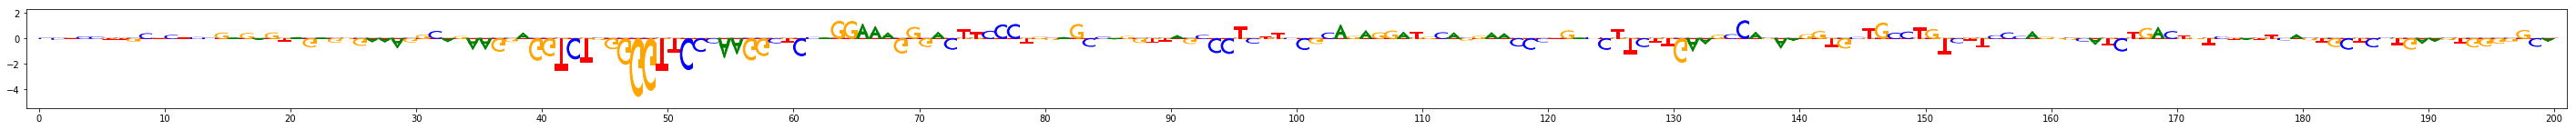

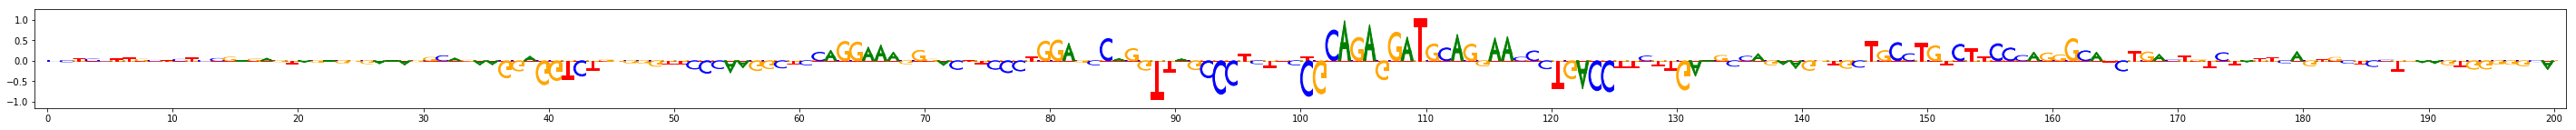

In [14]:
from deeplift.visualization import viz_sequence
viz_sequence.plot_weights(gradxinput_ref[400:600],figsize=(50, 2), subticks_frequency=10)
viz_sequence.plot_weights(gradxinput_alt[400:600],figsize=(50, 2), subticks_frequency=10)
viz_sequence.plot_weights(gradxinput_alt[400:600]-gradxinput_ref[400:600],figsize=(50, 2), subticks_frequency=10)

## DeeLIFT shuffled ref 

In [15]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores=dict() 
for t_index in [2,3]:
    dl_scores[tasks[t_index]]=dict() 
    for base in [ref,alt]:
        dl_scores[tasks[t_index]][base]=deeplift("v4/gecco.classification.SummitWithin200bpCenter."+str(fold),
                                         X[base],
                                         task_idx=t_index,
                                         num_refs_per_seq=1,
                                         batch_size=1,
                                         reference='shuffled_ref')

got score func!
got score func!
got score func!
got score func!


In [16]:
def plot_seq_importance(grads, x, xlim=None, ylim=None, layer_idx=-2, figsize=(25, 3),title="",snp_pos=101):
    """Plot  sequence importance score                                                                                                                   
                                                                                                                                                         
    Args:                                                                                                                                                
      grads: either deeplift or gradientxinput score matrix                                                                                              
      x: one-hot encoded DNA sequence                                                                                                                    
      xlim: restrict the plotted xrange                                                                                                                  
      figsize: matplotlib figure size                                                                                                                    
    """
    grads=grads.squeeze()
    x=x.squeeze()

    seq_len = x.shape[0]
    vals_to_plot=grads*x
    if xlim is None:
        xlim = (0, seq_len)
    if ylim is None:
        ylim= (np.amin(vals_to_plot),np.amax(vals_to_plot))
    seqlogo_fig(vals_to_plot, figsize=figsize)
    plt.xticks(list(range(xlim[0], xlim[1], 5)))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.axvline(x=snp_pos, color='k', linestyle='--')

In [17]:
def plot_dl(dl_scores,X,task,ref_allele,alt_allele,start_index=400,end_index=600,ylim_min=-0.4,ylim_max=0.4):
    tmp1=dl_scores[task][ref_allele][0].squeeze()[start_index:end_index]
    tmp2=X[ref_allele].squeeze()[start_index:end_index]
    print("ref:"+str(ref))
    print(plot_seq_importance(tmp1,tmp2,ylim=(ylim_min,ylim_max)))
    tmp3=dl_scores[task][alt_allele][0].squeeze()[start_index:end_index]
    tmp4=X[alt_allele].squeeze()[start_index:end_index]
    print("alt:"+str(alt))
    print(plot_seq_importance(tmp3,tmp4,ylim=(ylim_min,ylim_max)))
    print("alt - ref")
    print(plot_seq_importance(tmp3-tmp1,tmp4,ylim=(ylim_min,ylim_max)))
    return

ref:T
None
alt:C
None
alt - ref
None


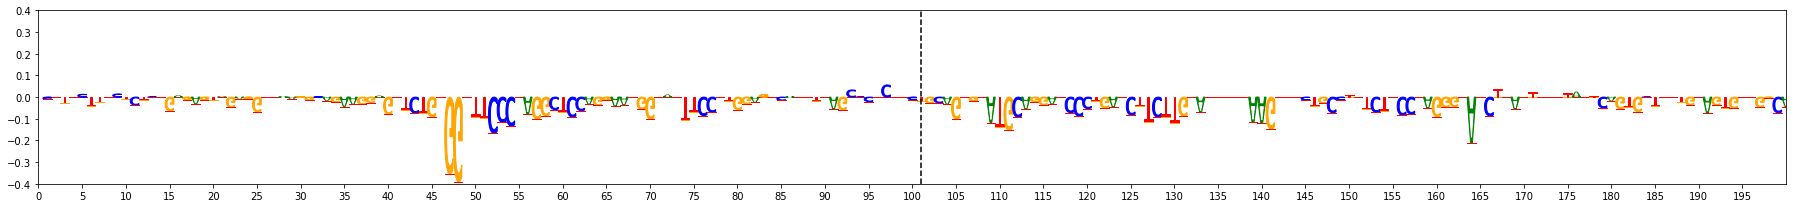

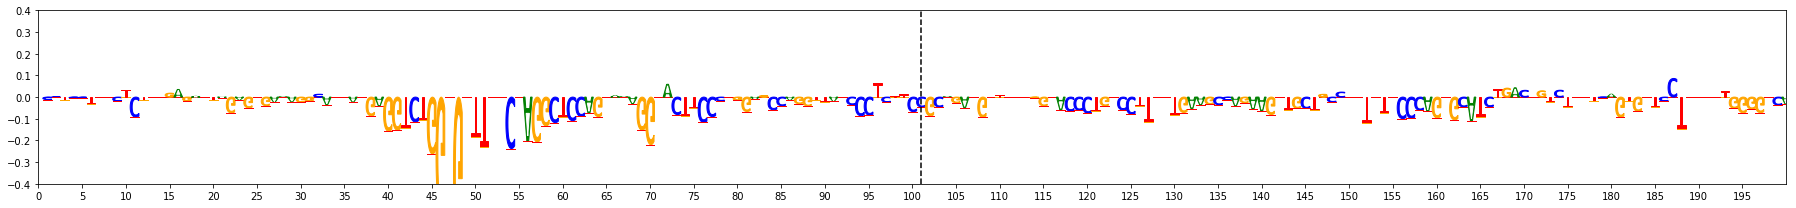

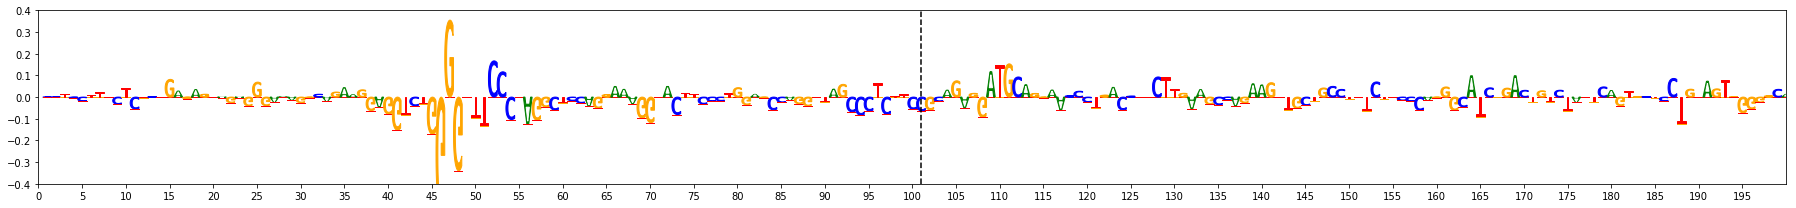

In [18]:
plot_dl(dl_scores,X,"SW480",ref,alt)  

ref:T
None
alt:C
None
alt - ref
None


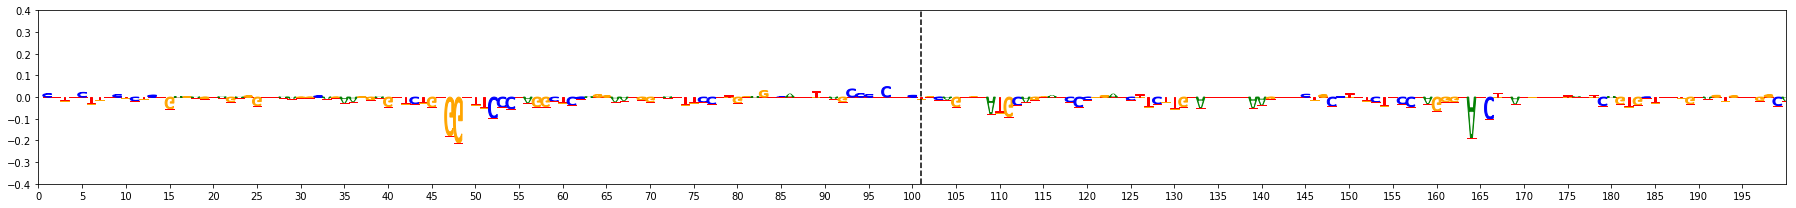

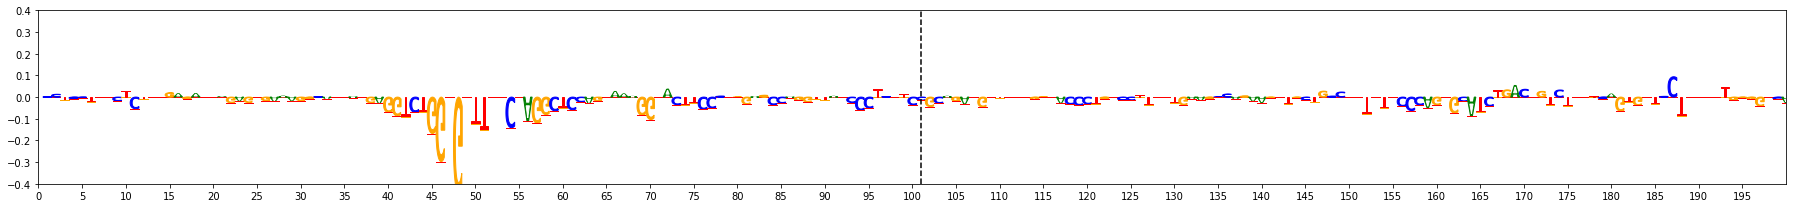

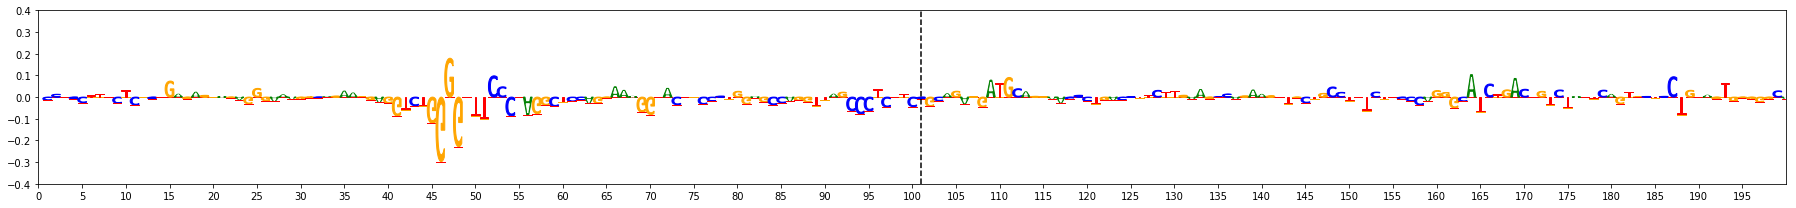

In [19]:
plot_dl(dl_scores,X,"HCT116",ref,alt)  